In [1]:
import numpy as np
import librosa
from matplotlib import pyplot as plt
import scipy.ndimage
import IPython.display as display

[-0.20739746 -0.20700073 -0.19830322 -0.18792725 -0.18096924 -0.16778564
 -0.1642456  -0.15145874 -0.15008545 -0.04696655  0.07485962  0.16741943
  0.31503296  0.29849243  0.3152771   0.3951416   0.42416382  0.45837402
  0.52423096  0.5119934   0.5274048   0.6119995 ]


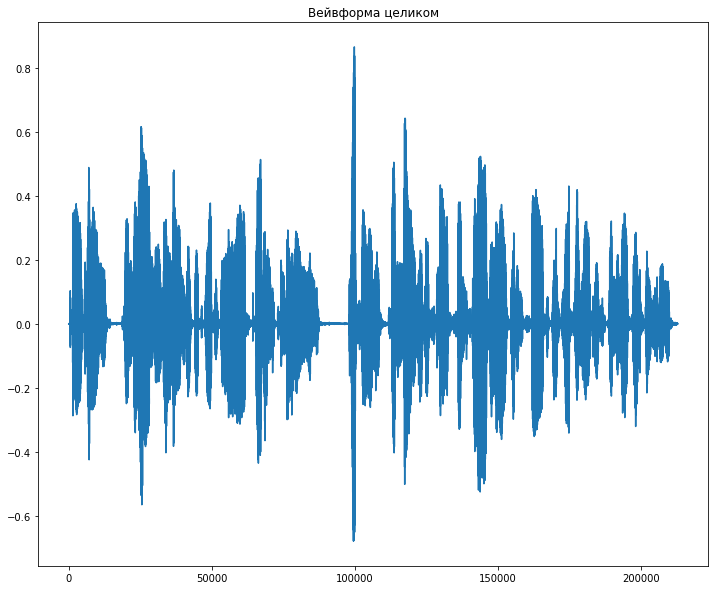

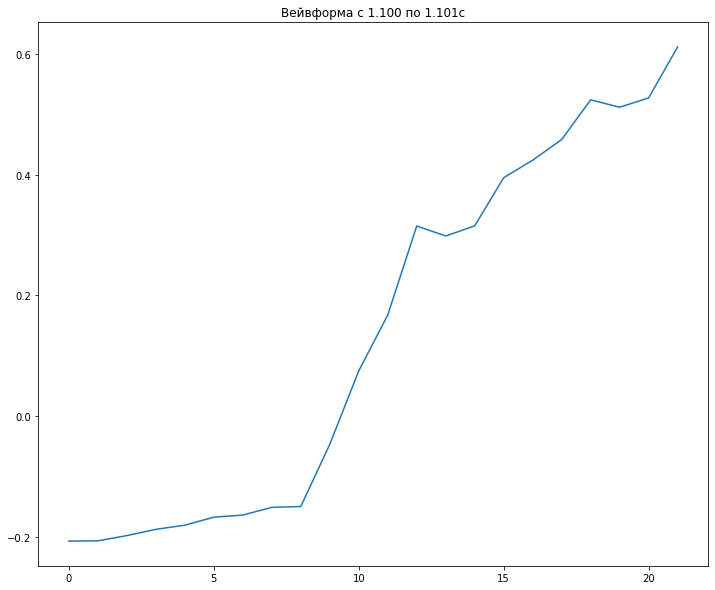

In [3]:
audio, rate = librosa.load('LJ001-0001.wav')
# 22050
plt.figure(figsize=(12, 10))
plt.title('Вейвформа целиком')
plt.plot(audio)

plt.figure(figsize=(12, 10))
plt.title('Вейвформа с 1.100 по 1.101с')
print(audio[int(rate*1.15):int(rate*1.151)])
plt.plot(audio[int(rate*1.15):int(rate*1.151)])


Изучаем частоту Найквиста

In [4]:
print(rate)

def resample(audio, scale=2):
    subscaled = audio[::scale]
    return scipy.ndimage.zoom(subscaled, scale)

22050


In [5]:
audio_11khz = resample(audio, 2)
audio_5500hz = resample(audio, 4)
audio_2750hz = resample(audio, 8)
audio_1325hz = resample(audio, 16)
audio_345hz = resample(audio, 64)

In [6]:
display.Audio(audio_345hz, rate=rate)

Time-frequency domain

(212893,)
(1025, 416)
[[ 1.2619099e-02+0.0000000e+00j  9.1606174e-03+0.0000000e+00j
  -1.0203625e-02+0.0000000e+00j ... -2.5717653e-03+0.0000000e+00j
  -1.2333941e-03+0.0000000e+00j  4.0007471e-03+0.0000000e+00j]
 [-1.9342615e-03-3.1830228e-17j -1.1981231e-02-3.2280651e-03j
   7.9854270e-03-1.5830161e-02j ...  1.2197356e-03+8.3924324e-04j
   1.0820812e-03+1.8125599e-04j -1.0095299e-03+5.6524631e-03j]
 [-9.2102773e-03-7.0651184e-18j  1.1841416e-02-1.8487466e-03j
  -3.9972221e-03+8.2758013e-03j ...  6.8389537e-04-1.0203902e-03j
   5.5283448e-04+2.2779460e-04j -5.7911105e-03-2.4241335e-03j]
 ...
 [ 3.1388874e-05+5.7345769e-19j -1.0584753e-04+2.0754144e-04j
   3.8998605e-05-2.6200979e-04j ... -5.8154317e-05-1.1918421e-04j
   4.1239051e-05+3.4974444e-05j -3.1075155e-04+1.6613523e-04j]
 [-6.9755552e-05-2.1349465e-18j -2.0112631e-04-1.4310665e-04j
  -2.4432951e-04+1.6565638e-04j ...  8.0345017e-05+2.2848933e-04j
   2.3852366e-04+8.9241163e-05j  2.3121112e-04-2.2645744e-04j]
 [ 2.1525014e-04+0

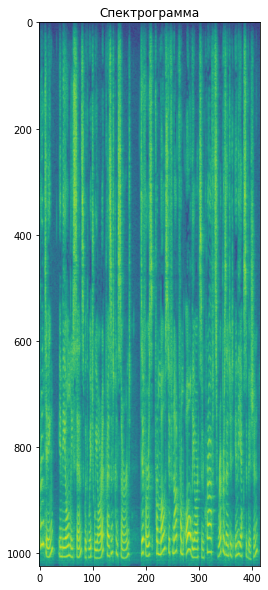

In [7]:
print(audio.shape)
stft = librosa.core.stft(audio)
print(stft.shape)
print(stft)
print(stft.shape[0] * stft.shape[1])

spectrogram = np.abs(stft)
phase = np.angle(stft)
print(spectrogram.shape, phase.shape)

plt.figure(figsize=(20, 10))
plt.title('Спектрограмма')
plt.imshow(np.log(1.e-8 + spectrogram)[::-1])  # логарифм для красоты

# plt.figure(figsize=(12, 10))
# plt.title('Фаза')
# plt.imshow(phase)

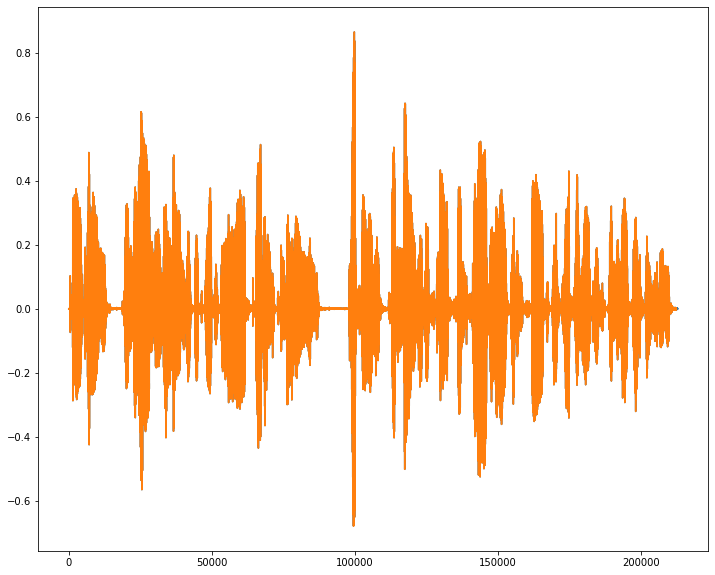

In [8]:
restored_audio = librosa.core.istft(spectrogram * np.exp(1j * phase))

plt.figure(figsize=(12,10))
plt.plot(audio)
plt.plot(restored_audio)

Пробуем алгоритм pitch-shift

In [9]:
def pitch_shift(audio, scale):
    freq_bins = spectrogram.shape[0]
    num_frames = spectrogram.shape[1]
    log_spectrogram = np.log(1.e-8 + spectrogram)
    
    if scale < 1:
        shifted_spectrogram = scipy.ndimage.zoom(log_spectrogram[:int(freq_bins * scale)], (1./scale, 1))
        shifted_phase = scipy.ndimage.zoom(phase[:int(freq_bins * scale)], (1./scale, 1))
    else:
        shifted_spectrogram = scipy.ndimage.zoom(log_spectrogram, (1./scale, 1))
        shifted_phase = scipy.ndimage.zoom(phase, (1./scale, 1))
        # матрицы уменьшились, нужно дополнить их нулями
        shifted_spectrogram = np.vstack((shifted_spectrogram, np.log(1.e-8) + np.zeros((freq_bins - shifted_spectrogram.shape[0], num_frames))))
        shifted_phase = np.vstack((shifted_phase, np.zeros((freq_bins - shifted_phase.shape[0], num_frames))))

    return np.exp(shifted_spectrogram), shifted_phase
    

(1025, 416) (1025, 416)


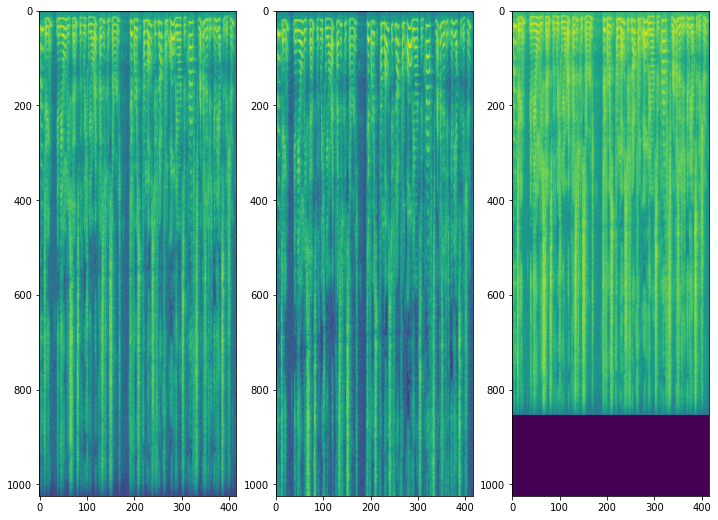

In [10]:
lower_spectrogram, lower_phase = pitch_shift(audio, 0.8)
higher_spectrogram, higher_phase = pitch_shift(audio, 1.2)

log_spectrogram = np.log(1.e-8 + spectrogram)

print(lower_spectrogram.shape, higher_spectrogram.shape)
plt.figure(figsize=(12, 10))
plt.subplot(131)
plt.imshow(log_spectrogram)
plt.subplot(132)
plt.imshow(np.log(lower_spectrogram))
plt.subplot(133)
plt.imshow(np.log(higher_spectrogram))



In [11]:
lower_audio = librosa.core.istft(lower_spectrogram * np.exp(1j * lower_phase))
higher_audio = librosa.core.istft(higher_spectrogram * np.exp(1j * higher_phase))

display.Audio(higher_audio, rate=rate)

In [12]:
display.Audio(lower_audio, rate=rate)

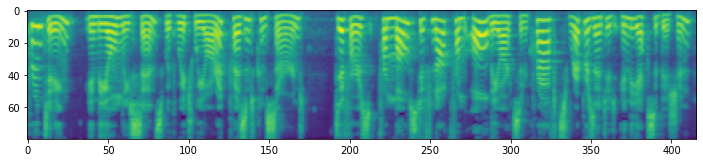

In [13]:
mel_spectrogram = librosa.feature.melspectrogram(audio, n_mels=80)
plt.figure(figsize=(12, 10))
plt.imshow(np.log(1.e-8 + mel_spectrogram))

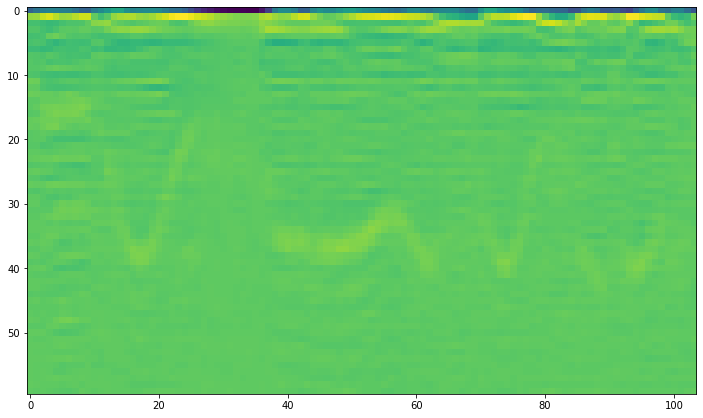

In [14]:
mfcc = librosa.feature.mfcc(audio[:len(audio)//4], n_mfcc=60)
plt.figure(figsize=(12, 10))
plt.imshow(mfcc)

Домашнее задание:

Алгоритм Гриффина-Лима (Griffin-Lim)

In [33]:
def griffin_lim(spectrogram, iterations=1, window_size=2048, hop_length=512, show_norm=False):
    time_samples = spectrogram.shape[1]
    len_samples = int(time_samples * hop_length - hop_length)
    magnitude_spectrogram = np.abs(spectrogram)
    x_recov = np.random.randn(len_samples)
    
    for i in range(iterations):
        recov_spectrogram = librosa.core.stft(x_recov)
        recov_angle = np.angle(recov_spectrogram)
        prob_spectrogram = np.exp(1j * recov_angle) * magnitude_spectrogram
        x_prev = x_recov
        x_recov = librosa.core.istft(prob_spectrogram)
        norm = np.sqrt(np.sum((x_recov - x_prev) ** 2) / len(x_recov))
        if show_norm:
            print(f"Norm on {i} iteration = {norm}")
    return x_recov

In [32]:
# def griffin_lim(spectrogram, iterations=1):
#     restored = 'реализация алгоритма Гриффина-Лима'    
#     return restored
    

In [34]:
audio_iter1 = griffin_lim(spectrogram, iterations=1)
display.Audio(audio_iter1, rate=rate)

In [37]:
audio_iter10 = griffin_lim(spectrogram, iterations=10)
display.Audio(audio_iter10, rate=rate)

In [38]:
audio_iter100 = griffin_lim(spectrogram, iterations=100)
display.Audio(audio_iter100, rate=rate)

Пробуем озвучить мел-спектрограмму

(1025, 416)


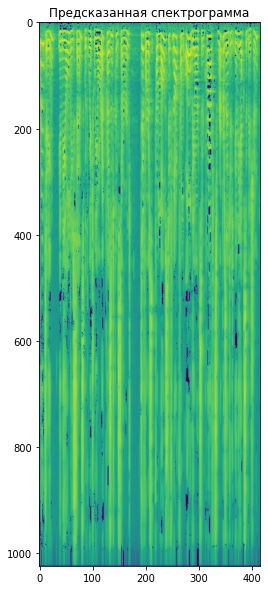

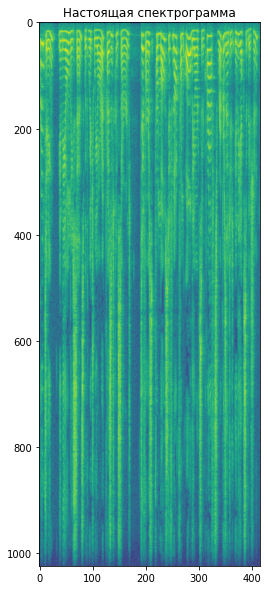

In [39]:
mel_spectrogram = librosa.feature.melspectrogram(audio)

restored_spectrogram = librosa.feature.inverse.mel_to_stft(mel_spectrogram)
print(restored_spectrogram.shape)

plt.figure(figsize=(12, 10))
plt.title('Предсказанная спектрограмма')
plt.imshow(np.log(1.e-8 + restored_spectrogram))
plt.figure(figsize=(12, 10))
plt.title('Настоящая спектрограмма')
plt.imshow(np.log(1.e-8 + spectrogram))



In [40]:
restored_audio = griffin_lim(restored_spectrogram, iterations=100)
display.Audio(restored_audio, rate=rate)